In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import os


In [2]:
users_df = pd.read_csv('takehome_users.csv', encoding = 'ISO-8859-1')

In [3]:
ue_df = pd.read_csv('takehome_user_engagement.csv')

In [4]:
ue_df

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
...,...,...,...
207912,2013-09-06 06:14:15,11996,1
207913,2013-01-15 18:28:37,11997,1
207914,2014-04-27 12:45:16,11998,1
207915,2012-06-02 11:55:59,11999,1


In [5]:
users_df

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0
...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,NaN
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074.0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,NaN


In [6]:
users_df.rename(columns = {"object_id":"user_id"}, inplace = True)


In [7]:
users_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   user_id                     12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [8]:
users_df.isna().sum()


user_id                          0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64

In [9]:
ue_df.isna().sum()


time_stamp    0
user_id       0
visited       0
dtype: int64

In [10]:
ue_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [11]:
# Convert time_stamp to datetime format
ue_df.time_stamp = pd.to_datetime(ue_df.time_stamp)

In [12]:
ue_df.sort_values(by='time_stamp', inplace=True)


Now we want to find "adopted user", which is any user_id who logged in at least 3 times in any 7 day period. We should do this by creating a for loop searching for unique user_id showing up at least 3 times in the time_stamp column within a period of 7 days. 

In [13]:
import datetime as dt

# Create a dictionary to store whether a user has been adopted or not
adopted_dict = {id:0 for id in users_df.user_id}

# For each user id find if there are 3 logins within 7 days of each other.
# If and once found, set that user id in the dictionary to 1 and move on to the next user id.
for id in ue_df.user_id.unique():
    query = ue_df.query(f'user_id == {id}')
    length = query.shape[0]
    for idx in range(length - 2):
        start = query.iloc[idx, 0]
        end = query.iloc[idx + 2, 0]
        time_range = start + dt.timedelta(days=7)
        if end < time_range:
            adopted_dict[id] = 1
            break

In [14]:
# Add dictionary values to users DataFrame
users_df['adopted'] = users_df.user_id.apply(lambda x: adopted_dict[x])

### Modeling

In [15]:
users_ML = users_df.copy(deep=True)

In [16]:
users_ML.creation_time = pd.to_datetime(users_ML.creation_time).apply(lambda x: x.value)

In [17]:
users_ML.last_session_creation_time	 = pd.to_datetime(users_ML.last_session_creation_time	).apply(lambda x: x.value)

In [18]:
users_ML

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,1398138810000000000,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1398138810,1,0,11,10803.0,0
1,2,1384487104000000000,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1396237504,0,0,1,316.0,1
2,3,1363734892000000000,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1363734892,0,0,94,1525.0,0
3,4,1369123768000000000,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1369210168,0,0,1,5151.0,0
4,5,1358417660000000000,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1358849660,0,0,193,5240.0,0
...,...,...,...,...,...,...,...,...,...,...,...
11995,11996,1378448055000000000,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1378448055,0,0,89,8263.0,0
11996,11997,1357842517000000000,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1358274517,0,0,200,NaN,0
11997,11998,1398602716000000000,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1398602716,1,1,83,8074.0,0
11998,11999,1338465359000000000,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1338638159,0,0,6,NaN,0


In [19]:
# Convert categorical column to numeric
users_ML = pd.get_dummies(users_ML, columns=['creation_source'])

# Remove unhelpful columns
users_ML = users_ML.drop(columns=['user_id','name','email'])

In [20]:
# Fill NaNs with 0
users_ML.fillna(0, inplace=True)

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
X = users_ML.drop(columns='adopted')
y = users_ML.adopted
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate

In [24]:
tree = DecisionTreeClassifier(max_depth=4)
cv = cross_validate(tree, X, y, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.8s finished


In [26]:
cv

{'fit_time': array([0.02254534, 0.02253175, 0.02203488, 0.0235002 , 0.01592588]),
 'score_time': array([0.00237393, 0.00261307, 0.00241804, 0.00271893, 0.00177383]),
 'test_score': array([0.965     , 0.96125   , 0.96416667, 0.95666667, 0.95625   ])}

In [27]:
tree = DecisionTreeClassifier(max_depth=4)
tree.fit(X_train, y_train)
tree.score(X_test, y_test)

0.958

In [28]:
pd.DataFrame(data=tree.feature_importances_, index=X_train.columns).sort_values(by=0, ascending=False)

,0
last_session_creation_time,0.628273
creation_time,0.369676
invited_by_user_id,0.002051
opted_in_to_mailing_list,0.000000
enabled_for_marketing_drip,0.000000
org_id,0.000000
creation_source_GUEST_INVITE,0.000000
creation_source_ORG_INVITE,0.000000
creation_source_PERSONAL_PROJECTS,0.000000
creation_source_SIGNUP,0.000000


In [29]:
def gen_corr_to_target(dataframe, target, title=None, annot=False, save=None):
    '''Generate a correlation heatmap between the target feature and other features'''
    plt.figure(figsize=(4, 6))
    sns.set(font_scale=1)

    sns.heatmap(dataframe.corr()[[target]].sort_values(target, ascending=False)[1:], vmin=-1, vmax=1,
                center=0, annot=annot, cmap='bwr')

    if title:
        plt.title(f'\n{title}\n', fontsize=18)
        
    if save:
        filepath = title + '.png'
        save_and_show_plot(filepath)

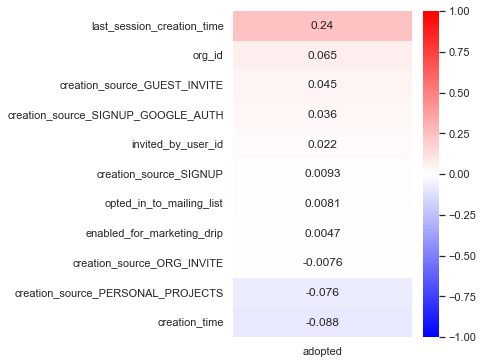

In [30]:
gen_corr_to_target(users_ML, 'adopted', annot=True)